<a href="https://colab.research.google.com/github/badrmarani/case-study-pfizer-tr-market-coverage/blob/master/case_study_pfizer_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reset -f

In [ ]:
!pip install --quiet gurobipy scienceplots latex

In [ ]:
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [ ]:
import scienceplots

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import itertools
from tqdm.notebook import tqdm

import os
os.makedirs("figures/", exist_ok=True)


In [ ]:
params = {
    "WLSACCESSID": os.environ["WLSACCESSID"],
    "WLSSECRET": os.environ["WLSSECRET"],
    "LICENSEID": os.environ["LICENSEID"],
}

env = gp.Env(params=params)


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2440453
Academic license 2440453 - for non-commercial use only - registered to ba___@student-cs.fr


In [ ]:
def convert_dict_to_binary_matrix(d):
    df = pd.concat([
            pd.Series(v, name=k).astype(str) for k, v in d.items()
        ],
        axis=1
    )
    df = pd.get_dummies(df.stack()).groupby(level=1).sum().clip(upper=1)
    df.columns = [int(c) for c in df.columns]
    df = df.reindex(sorted(df.columns), axis=1)
    return df.values

def get_report(assignments):
    """This function takes the best optimal solution found by Gurobi
    and generate a `smallish` report as to ease reading the results.
    """
    t = assignments.argmax(axis=0) + 1

    solution = {}
    bricks = np.arange(1, num_bricks+1)
    for i in range(1, 4+1):
        indices = np.nonzero(t == i)
        solution[i] = (
            distances[i-1, indices].sum(),
            index_values[indices].sum(),
            bricks[indices]
        )

    print("Structure of Sales Territories:")
    for k, v in solution.items():
        distance_per_sr, index_value_per_sr, assigned_bricks = v
        print(f"SR{k} (iv:{index_value_per_sr:.3f} - distance:{distance_per_sr:.3f}):", assigned_bricks)

    total_distance = np.sum(distances*assignments)
    disruption = np.sum((assignments - x_current_structure)**2 * index_values / 2)

    print("Disruption:", disruption)
    print("Total distance:", total_distance)
    return disruption, total_distance


# Parameters

In [ ]:
current_structure_of_sales_territories = {
    1: [4, 5, 6, 7, 8, 15],
    2: [10, 11, 12, 13, 14],
    3: [9, 16, 17, 18],
    4: [1, 2, 3, 19, 20, 21, 22]
}

x_current_structure = convert_dict_to_binary_matrix(current_structure_of_sales_territories)

In [ ]:
distances_df = pd.read_excel("/content/distances.xlsx", index_col=1, header=1)
distances_df.dropna(inplace=True, axis=1)
distances = distances_df.values.T

distances_between_bricks_df = pd.read_excel("/content/distances.xlsx", index_col=1, header=1, sheet_name=1)
distances_between_bricks_df.dropna(inplace=True, axis=1)
distances_between_bricks = distances_between_bricks_df.values

index_values_df = pd.read_excel(
    "/content/indexValues.xlsx",
    header=None,
    names=["brick", "index_value"],
    index_col=0
)
index_values = index_values_df.values.squeeze(1)



In [ ]:
num_bricks = distances_df.shape[0]
num_sr = distances_df.shape[1]

print("Number of bricks:", num_bricks)
print("Number of sales representatives:", num_sr)


Number of bricks: 22
Number of sales representatives: 4


In [ ]:
results = {
    "disruption": [],
    "total_distance": [],
}

In [ ]:
# current structure
disruption, total_distance = get_report(assignments=x_current_structure)

results["disruption"].append(disruption)
results["total_distance"].append(total_distance)


Structure of Sales Territories:
SR1 (iv:0.951 - distance:19.300): [ 4  5  6  7  8 15]
SR2 (iv:1.338 - distance:33.320): [10 11 12 13 14]
SR3 (iv:0.705 - distance:10.050): [ 9 16 17 18]
SR4 (iv:1.007 - distance:124.740): [ 1  2  3 19 20 21 22]
Disruption: 0.0
Total distance: 187.41


# Mathematical Formulation

In [ ]:
def add_workload_balance_constraint(model, index_values, x, lb, ub, num_bricks, num_sr):
    model.addConstrs((
        lb <= gp.quicksum(index_values[j] * x[i][j] for j in range(num_bricks))
        for i in range(num_sr)
    ), name="left_workload_balance")

    model.addConstrs((
        gp.quicksum(index_values[j] * x[i][j] for j in range(num_bricks)) <= ub
        for i in range(num_sr)
    ), name="right_workload_balance")

    return model

def add_no_partial_assignment_cosntraint(model, x, num_bricks, num_sr):
    model.addConstrs((
        gp.quicksum(x[i][j] for i in range(num_sr)) == 1
        for j in range(num_bricks)
    ), name="no_partial_assignments")

    return model

def add_constraints(model, index_values, x, lb, ub, num_bricks, num_sr):
    model.update()
    model = add_workload_balance_constraint(model, index_values, x, lb, ub, num_bricks, num_sr)
    model = add_no_partial_assignment_cosntraint(model, x, num_bricks, num_sr)
    return model


In [ ]:
def get_ideal_nadir_point(
    workload_balance_lower_bound: float,
    workload_balance_upper_bound: float,
):
    model = gp.Model("pfizer")
    model.params.outputflag = 0

    # Decision variables
    x = model.addMVar((num_sr, num_bricks), vtype=GRB.BINARY)

    # Add constraints
    model = add_constraints(model, index_values, x, lb=workload_balance_lower_bound, ub=workload_balance_upper_bound, num_bricks=num_bricks, num_sr=num_sr)

    # Minimize the total distance
    model.setObjective(
        gp.quicksum(
            distances[i][j] * x[i][j]
            for i in range(num_sr)
            for j in range(num_bricks)
        ),
        GRB.MINIMIZE
    )

    model.update()
    model.optimize()
    max_disruption, max_total_distance = get_report(assignments=x.x)
    min_disruption, min_total_distance = get_report(assignments=x.x)


    model = gp.Model("pfizer")
    model.params.outputflag = 0

    # Decision variables
    x = model.addMVar((num_sr, num_bricks), vtype=GRB.BINARY)

    # Add constraints
    model = add_constraints(model, index_values, x, lb=workload_balance_lower_bound, ub=workload_balance_upper_bound, num_bricks=num_bricks, num_sr=num_sr)

    # Minimize the total disruption between SRs
    model.setObjective(
        gp.quicksum(
            index_values[j] * (x[i][j] - x_current_structure[i][j]) * (x[i][j] - x_current_structure[i][j]) / 2
            for i in range(num_sr)
            for j in range(num_bricks)
        ),
        GRB.MINIMIZE
    )

    model.update()
    model.optimize()
    disruption, total_distance = get_report(assignments=x.x)


    min_disruption = min(min_disruption, disruption)
    min_total_distance = min(min_total_distance, total_distance)

    max_disruption = max(max_disruption, disruption)
    max_total_distance = max(max_total_distance, total_distance)

    return min_disruption, min_total_distance, max_disruption, max_total_distance

# Mono-objective problem

## Minimize the totale distance

In [ ]:
lb = 0.8
ub = 1.2

In [ ]:
model = gp.Model("pfizer")

# Decision variables
x = model.addMVar((num_sr, num_bricks), vtype=GRB.BINARY)

# Add constraints
model = add_constraints(model, index_values, x, lb=lb, ub=ub, num_bricks=num_bricks, num_sr=num_sr)

# Minimize the total distance
model.setObjective(
    gp.quicksum(
        distances[i][j] * x[i][j]
        for i in range(num_sr)
        for j in range(num_bricks)
    ),
    GRB.MINIMIZE
)

model.update()
model.optimize()


Restricted license - for non-production use only - expires 2025-11-24
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 30 rows, 88 columns and 264 nonzeros
Model fingerprint: 0x45a7461b
Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [8e-01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 346.1500000
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)
Found heuristic solution: objective 256.3500000

Root relaxation: objective 1.488330e+02, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  

In [ ]:
disruption, total_distance = get_report(assignments=x.x)

results["disruption"].append(disruption)
results["total_distance"].append(total_distance)


Structure of Sales Territories:
SR1 (iv:1.038 - distance:64.370): [ 4  5  6  7  8  9 12 19 20]
SR2 (iv:1.045 - distance:7.530): [11 13 14 18]
SR3 (iv:1.115 - distance:6.570): [10 15 16 17]
SR4 (iv:0.803 - distance:76.130): [ 1  2  3 21 22]
Disruption: 1.2055
Total distance: 154.6


## Minimize the total disruption between SRs

In [ ]:
model = gp.Model("pfizer")

# Decision variables
x = model.addMVar((num_sr, num_bricks), vtype=GRB.BINARY)

# Add constraints
model = add_constraints(model, index_values, x, lb=0.8, ub=1.2, num_bricks=num_bricks, num_sr=num_sr)

# Minimize the total disruption between SRs
model.setObjective(
    gp.quicksum(
        index_values[j] * (x[i][j] - x_current_structure[i][j]) * (x[i][j] - x_current_structure[i][j]) / 2
        for i in range(num_sr)
        for j in range(num_bricks)
    ),
    GRB.MINIMIZE
)

model.update()
model.optimize()


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 30 rows, 88 columns and 264 nonzeros
Model fingerprint: 0xcdcbe25c
Model has 88 quadratic objective terms
Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [4e-02, 8e-01]
  QObjective range [4e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 3.0391000
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)
Found heuristic solution: objective 1.9127000

Root relaxation: objective 1.377000e-01, 10 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  O

In [ ]:
disruption, total_distance = get_report(assignments=x.x)

results["disruption"].append(disruption)
results["total_distance"].append(total_distance)


Structure of Sales Territories:
SR1 (iv:0.951 - distance:19.300): [ 4  5  6  7  8 15]
SR2 (iv:1.168 - distance:7.820): [10 13 14]
SR3 (iv:0.874 - distance:37.090): [ 9 11 12 16 17 18]
SR4 (iv:1.007 - distance:124.740): [ 1  2  3 19 20 21 22]
Disruption: 0.1696
Total distance: 188.95


In [ ]:
df = pd.DataFrame(
    results,
    index=[
        "Current structure",
        "Minimizing the total distance",
        "Minimizing the total disruption",
    ]
)

df.rename(columns={
    "disruption": "Disruption",
    "total_distance": "Total distance",
}, inplace=True)

df

,Disruption,Total distance
Current structure,0.0000,187.41
Minimizing the total distance,1.2055,154.60
Minimizing the total disruption,0.1696,188.95


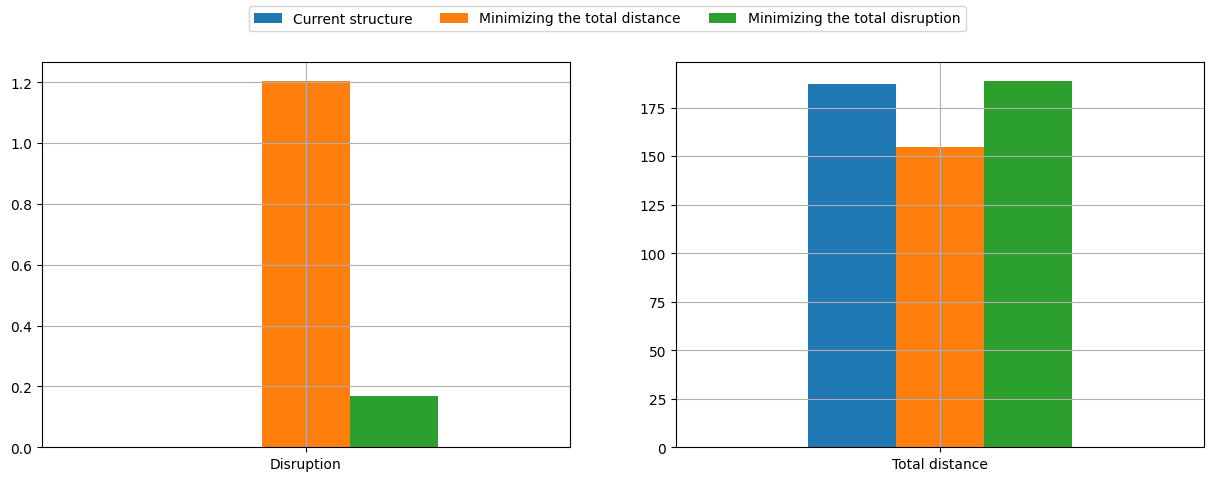

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df.T.iloc[[0], :].plot(kind="bar", ax=axes[0], legend=False, grid=True, rot=0)
df.T.iloc[[1], :].plot(kind="bar", ax=axes[1], legend=False, grid=True, rot=0)

lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', ncol=3)

# Multi-objective problem

## The $\varepsilon$ - constraint method

In [ ]:
def epsilon_constrain_method(
    x_current_structure,
    index_values,
    error: float = 1e-3,
    workload_balance_lower_bound: float = 0.8,
    workload_balance_upper_bound: float = 1.2,
):

    F1, F2 = [], []
    X = []

    epsilon = math.inf

    for i in tqdm(itertools.count(start=1)):
        model = gp.Model("pfizer", env=env)
        model.params.outputflag = 0

        # Decision variables
        x = model.addMVar((num_sr, num_bricks), vtype=GRB.BINARY)

        # Constraints
        model = add_constraints(model, index_values, x, lb=workload_balance_lower_bound, ub=workload_balance_upper_bound, num_bricks=num_bricks, num_sr=num_sr)

        # The epsilon constraint
        model.addConstr(
            gp.quicksum(
                index_values[j] * (x[i][j] - x_current_structure[i][j])*(x[i][j] - x_current_structure[i][j]) / 2
                for i in range(num_sr)
                for j in range(num_bricks)
            ) <= epsilon,
            name="disruption"
        )

        # Minimize the total distance
        model.setObjective(
            gp.quicksum(
                distances[i][j] * x[i][j]
                for i in range(num_sr)
                for j in range(num_bricks)
            ),
            GRB.MINIMIZE
        )

        model.update()
        model.optimize()

        if model.status == 3:
            print(
                "Model was proven to be unbounded.",
                "No more non-dominated solutions."
            )
            break
        else:
            f1 = model.getObjective().getValue()
            f2 =  sum(
                index_values[j] * (x.x[i][j] - x_current_structure[i][j])**2 / 2
                for i in range(num_sr)
                for j in range(num_bricks)
            )

            F1.append(f1)
            F2.append(f2)
            X.append(x.x)

            epsilon = f2 - error
            print(f"Iteration {i}: f1:{f1:.3f}, f2:{f2:.3f}")

    return F1, F2, X


## The weighted sum

In [ ]:
def weighted_sum_method(
    x_current_structure,
    index_values,
    weights,
    workload_balance_lower_bound: float = 0.8,
    workload_balance_upper_bound: float = 1.2,
):
    F1, F2 = [], []
    X = []

    for w in tqdm(weights):
        model = gp.Model("pfizer", env=env)
        model.params.outputflag = 0

        # decision variables
        x = model.addMVar((num_sr, num_bricks), vtype=GRB.BINARY)

        # Constraints
        model = add_constraints(model, index_values, x, lb=workload_balance_lower_bound, ub=workload_balance_upper_bound, num_bricks=num_bricks, num_sr=num_sr)

        # minimize the weighted sum between the total distance and the disruption
        f1f2 =  gp.quicksum(
            distances[i][j] * x[i][j] + w * index_values[j] * (x[i][j] - x_current_structure[i][j]) * (x[i][j] - x_current_structure[i][j]) / 2
            for i in range(num_sr)
            for j in range(num_bricks)
        )

        model.setObjective(f1f2, GRB.MINIMIZE)
        model.update()
        model.optimize()

        f1 = sum(
            distances[i][j] * x.x[i][j]
            for i in range(num_sr)
            for j in range(num_bricks)
        )
        f2 = sum(
            index_values[j] * (x.x[i][j] - x_current_structure[i][j])**2 / 2
            for i in range(num_sr)
            for j in range(num_bricks)
        )

        F1.append(f1)
        F2.append(f2)
        X.append(x.x)

    return F1, F2, X


## Summary

In [ ]:
lb = 0.8
ub = 1.2

F1_epsilon_method_no_partial_assignement, F2_epsilon_method_no_partial_assignement, X = epsilon_constrain_method(
    x_current_structure,
    index_values=index_values,
    error=1e-4,
    workload_balance_lower_bound=lb,
    workload_balance_upper_bound=ub,
)

weights = np.linspace(0.0, 200.0, 100)
F1_weighted_no_partial_assignement, F2_weighted_no_partial_assignement, X = weighted_sum_method(
    x_current_structure=x_current_structure,
    index_values=index_values,
    weights=weights,
    workload_balance_lower_bound=lb,
    workload_balance_upper_bound=ub,
)

logs = []
logs.append([f"{lb}, {ub}", F1_weighted_no_partial_assignement, F2_weighted_no_partial_assignement])

# ideal and nadir point
ideal_disruption, ideal_distance, nadir_disruption, nadir_distance = get_ideal_nadir_point(lb, ub)


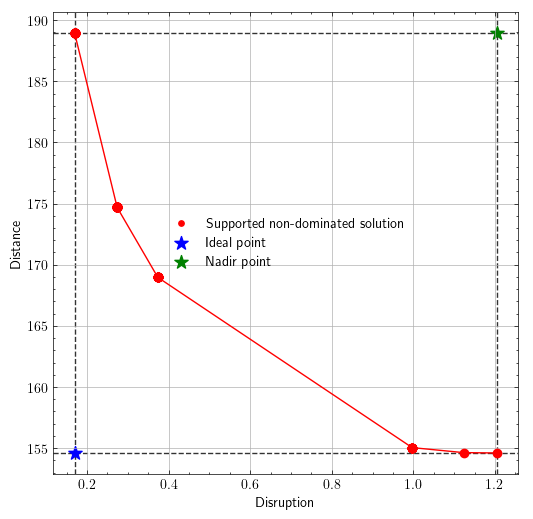

In [ ]:
 with plt.style.context('science'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    # ax.scatter(F2_epsilon_method_no_partial_assignement, F1_epsilon_method_no_partial_assignement, marker="o", c="k", s=15, label="Non-dominated solution")
    ax.scatter(F2_weighted_no_partial_assignement, F1_weighted_no_partial_assignement, marker="o", s=15, c="r", zorder=2.5, label="Supported non-dominated solution")
    ax.plot(F2_weighted_no_partial_assignement, F1_weighted_no_partial_assignement, "-or", zorder=2.5)

    ax.scatter(ideal_disruption, ideal_distance, marker="*", s=100, c="b", label="Ideal point")
    ax.axvline(x=ideal_disruption, zorder=0, c="k", linestyle="--", alpha=0.8)
    ax.axhline(y=ideal_distance, zorder=0, c="k", linestyle="--", alpha=0.8)

    ax.scatter(nadir_disruption, nadir_distance, marker="*", s=100, c="g", label="Nadir point")
    ax.axvline(x=nadir_disruption, zorder=0, c="k", linestyle="--", alpha=0.8)
    ax.axhline(y=nadir_distance, zorder=0, c="k", linestyle="--", alpha=0.8)

    # ax.set_title(f"{lb}, {ub}")
    ax.set_xlabel("Disruption")
    ax.set_ylabel("Distance")
    ax.grid()
    ax.legend()

fig.savefig(f"figures/weighted_sum_method_{lb}_{ub}.pdf", dpi=500)
plt.show()

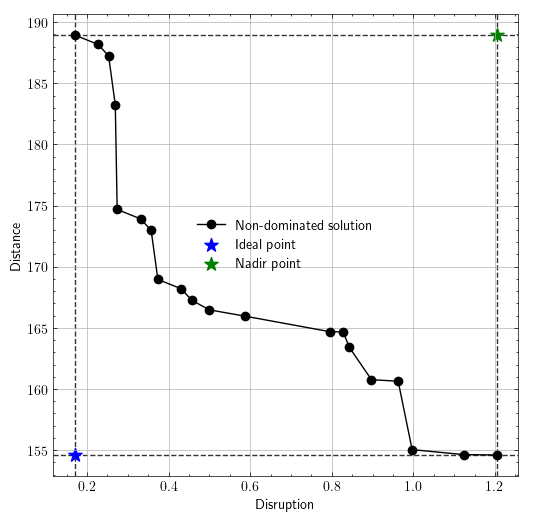

In [ ]:
 with plt.style.context('science'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.plot(F2_epsilon_method_no_partial_assignement, F1_epsilon_method_no_partial_assignement, "-ok", label="Non-dominated solution")
    # ax.scatter(F2_weighted_no_partial_assignement, F1_weighted_no_partial_assignement, marker="o", s=15, c="r", zorder=2.5, label="Supported non-dominated solution")
    # ax.plot(F2_weighted_no_partial_assignement, F1_weighted_no_partial_assignement, "-or", zorder=2.5)

    ax.scatter(ideal_disruption, ideal_distance, marker="*", s=100, c="b", label="Ideal point")
    ax.axvline(x=ideal_disruption, zorder=0, c="k", linestyle="--", alpha=0.8)
    ax.axhline(y=ideal_distance, zorder=0, c="k", linestyle="--", alpha=0.8)

    ax.scatter(nadir_disruption, nadir_distance, marker="*", s=100, c="g", label="Nadir point")
    ax.axvline(x=nadir_disruption, zorder=0, c="k", linestyle="--", alpha=0.8)
    ax.axhline(y=nadir_distance, zorder=0, c="k", linestyle="--", alpha=0.8)

    # ax.set_title(f"{lb}, {ub}")
    ax.set_xlabel("Disruption")
    ax.set_ylabel("Distance")
    ax.grid()
    ax.legend()

fig.savefig(f"figures/epsilon_constraint_method_{lb}_{ub}.pdf", dpi=500)
plt.show()


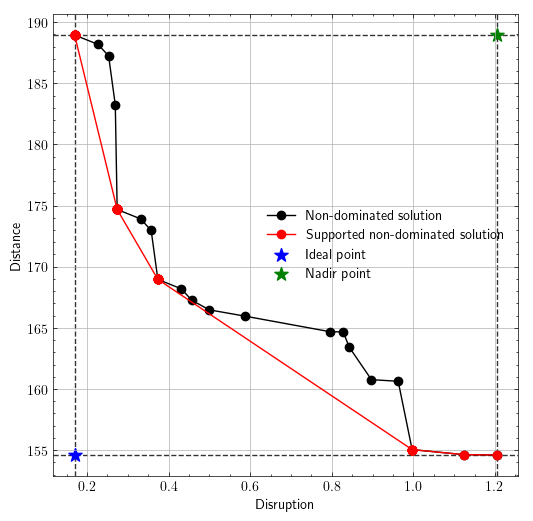

In [ ]:
 with plt.style.context('science'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.plot(F2_epsilon_method_no_partial_assignement, F1_epsilon_method_no_partial_assignement, "-ok", label="Non-dominated solution")
    # ax.scatter(F2_epsilon_method_no_partial_assignement, F1_epsilon_method_no_partial_assignement, marker="o", c="k", s=15, label="Non-dominated solution")
    # ax.scatter(F2_weighted_no_partial_assignement, F1_weighted_no_partial_assignement, marker="o", s=15, c="r", zorder=2.5, label="Supported non-dominated solution")
    ax.plot(F2_weighted_no_partial_assignement, F1_weighted_no_partial_assignement, "-or", zorder=2.5, label="Supported non-dominated solution")

    ax.scatter(ideal_disruption, ideal_distance, marker="*", s=100, c="b", label="Ideal point")
    ax.axvline(x=ideal_disruption, zorder=0, c="k", linestyle="--", alpha=0.8)
    ax.axhline(y=ideal_distance, zorder=0, c="k", linestyle="--", alpha=0.8)

    ax.scatter(nadir_disruption, nadir_distance, marker="*", s=100, c="g", label="Nadir point")
    ax.axvline(x=nadir_disruption, zorder=0, c="k", linestyle="--", alpha=0.8)
    ax.axhline(y=nadir_distance, zorder=0, c="k", linestyle="--", alpha=0.8)

    # ax.set_title(f"{lb}, {ub}")
    ax.set_xlabel("Disruption")
    ax.set_ylabel("Distance")
    ax.grid()
    ax.legend()

fig.savefig(f"figures/workload_balance_{lb}_{ub}.pdf", dpi=500)
plt.show()


# Questions

## How does varying the workload balance of each SR impact the solution?

In [ ]:
lb = 0.9
ub = 1.1

F1_eps, F2_eps, X = epsilon_constrain_method(
    x_current_structure,
    error=1e-4,
    index_values=index_values,
    workload_balance_lower_bound=lb,
    workload_balance_upper_bound=ub,
)

weights = np.linspace(0.0, 200.0, 100)
F1, F2, X = weighted_sum_method(
    x_current_structure=x_current_structure,
    index_values=index_values,
    weights=weights,
    workload_balance_lower_bound=lb,
    workload_balance_upper_bound=ub,
)

logs.append([f"{lb}, {ub}", F1, F2])

# ideal and nadir point
ideal_disruption, ideal_distance, nadir_disruption, nadir_distance = get_ideal_nadir_point(lb, ub)


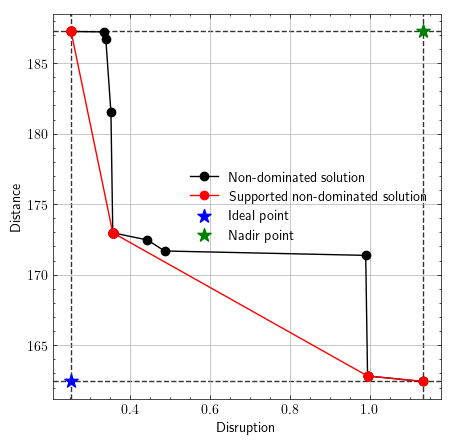

In [ ]:
with plt.style.context('science'):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    ax.plot(F2_eps, F1_eps, "-ok", label="Non-dominated solution")
    # ax.scatter(F2_eps, F1_eps, marker="o", c="k", s=15, label="Non-dominated solution")
    # ax.scatter(F2, F1, marker="o", s=15, c="r", zorder=2.5, label="Supported non-dominated solution")
    ax.plot(F2, F1, "-or", zorder=2.5, label="Supported non-dominated solution")

    ax.scatter(ideal_disruption, ideal_distance, marker="*", s=100, c="b", label="Ideal point")
    ax.axvline(x=ideal_disruption, zorder=0, c="k", linestyle="--", alpha=0.8)
    ax.axhline(y=ideal_distance, zorder=0, c="k", linestyle="--", alpha=0.8)

    ax.scatter(nadir_disruption, nadir_distance, marker="*", s=100, c="g", label="Nadir point")
    ax.axvline(x=nadir_disruption, zorder=0, c="k", linestyle="--", alpha=0.8)
    ax.axhline(y=nadir_distance, zorder=0, c="k", linestyle="--", alpha=0.8)

    # ax.set_title(f"{lb}, {ub}")
    ax.set_xlabel("Disruption")
    ax.set_ylabel("Distance")
    ax.grid()
    ax.legend()

fig.savefig(f"figures/workload_balance_{lb}_{ub}.pdf", dpi=500)
plt.show()


In [ ]:
lb = 0.7
ub = 1.3

F1_eps, F2_eps, X = epsilon_constrain_method(
    x_current_structure,
    error=1e-4,
    index_values=index_values,
    workload_balance_lower_bound=lb,
    workload_balance_upper_bound=ub,
)

weights = np.linspace(0.0, 200.0, 100)
F1, F2, X = weighted_sum_method(
    x_current_structure=x_current_structure,
    index_values=index_values,
    weights=weights,
    workload_balance_lower_bound=lb,
    workload_balance_upper_bound=ub,
)

logs.append([f"{lb}, {ub}", F1, F2])

# ideal and nadir point
ideal_disruption, ideal_distance, nadir_disruption, nadir_distance = get_ideal_nadir_point(lb, ub)


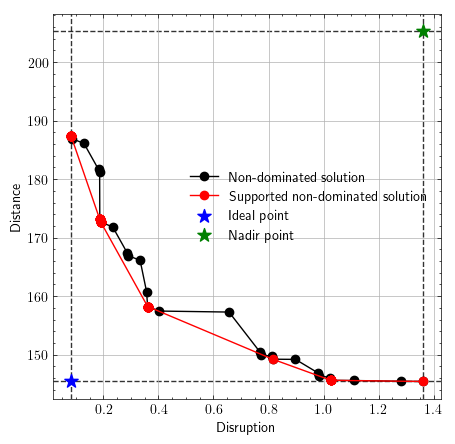

In [ ]:
with plt.style.context('science'):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    ax.plot(F2_eps, F1_eps, "-ok", label="Non-dominated solution")
    # ax.scatter(F2_eps, F1_eps, marker="o", c="k", s=15, label="Non-dominated solution")
    # ax.scatter(F2, F1, marker="o", s=15, c="r", zorder=2.5, label="Supported non-dominated solution")
    ax.plot(F2, F1, "-or", zorder=2.5, label="Supported non-dominated solution")

    ax.scatter(ideal_disruption, ideal_distance, marker="*", s=100, c="b", label="Ideal point")
    ax.axvline(x=ideal_disruption, zorder=0, c="k", linestyle="--", alpha=0.8)
    ax.axhline(y=ideal_distance, zorder=0, c="k", linestyle="--", alpha=0.8)

    ax.scatter(nadir_disruption, nadir_distance, marker="*", s=100, c="g", label="Nadir point")
    ax.axvline(x=nadir_disruption, zorder=0, c="k", linestyle="--", alpha=0.8)
    ax.axhline(y=nadir_distance, zorder=0, c="k", linestyle="--", alpha=0.8)

    # ax.set_title(f"{lb}, {ub}")
    ax.set_xlabel("Disruption")
    ax.set_ylabel("Distance")
    ax.grid()
    ax.legend()

fig.savefig(f"figures/workload_balance_{lb}_{ub}.pdf", dpi=500)
plt.show()


In [ ]:
lb = 0.6
ub = 1.4

F1_eps, F2_eps, X = epsilon_constrain_method(
    x_current_structure,
    error=1e-4,
    index_values=index_values,
    workload_balance_lower_bound=lb,
    workload_balance_upper_bound=ub,
)

weights = np.linspace(0.0, 200.0, 300)
F1, F2, X = weighted_sum_method(
    x_current_structure=x_current_structure,
    index_values=index_values,
    weights=weights,
    workload_balance_lower_bound=lb,
    workload_balance_upper_bound=ub,
)

logs.append([f"{lb}, {ub}", F1, F2])

# ideal and nadir point
ideal_disruption, ideal_distance, nadir_disruption, nadir_distance = get_ideal_nadir_point(lb, ub)


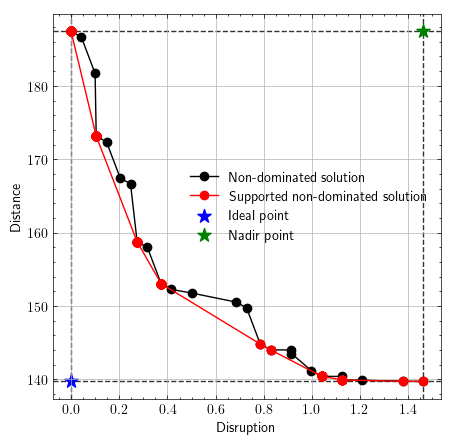

In [ ]:
with plt.style.context('science'):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    ax.plot(F2_eps, F1_eps, "-ok", label="Non-dominated solution")
    # ax.scatter(F2_eps, F1_eps, marker="o", c="k", s=15, label="Non-dominated solution")
    # ax.scatter(F2, F1, marker="o", s=15, c="r", zorder=2.5, label="Supported non-dominated solution")
    ax.plot(F2, F1, "-or", zorder=2.5, label="Supported non-dominated solution")

    ax.scatter(ideal_disruption, ideal_distance, marker="*", s=100, c="b", label="Ideal point")
    ax.axvline(x=ideal_disruption, zorder=0, c="k", linestyle="--", alpha=0.8)
    ax.axhline(y=ideal_distance, zorder=0, c="k", linestyle="--", alpha=0.8)

    ax.scatter(nadir_disruption, nadir_distance, marker="*", s=100, c="g", label="Nadir point")
    ax.axvline(x=nadir_disruption, zorder=0, c="k", linestyle="--", alpha=0.8)
    ax.axhline(y=nadir_distance, zorder=0, c="k", linestyle="--", alpha=0.8)

    # ax.set_title(f"{lb}, {ub}")
    ax.set_xlabel("Disruption")
    ax.set_ylabel("Distance")
    ax.grid()
    ax.legend()

fig.savefig(f"figures/workload_balance_{lb}_{ub}.pdf", dpi=500)
plt.show()


In [ ]:
lb = 0.0
ub = 2.0

F1_eps, F2_eps, X = epsilon_constrain_method(
    x_current_structure,
    error=1e-4,
    index_values=index_values,
    workload_balance_lower_bound=lb,
    workload_balance_upper_bound=ub,
)

weights = np.linspace(0.0, 200.0, 100)
F1, F2, X = weighted_sum_method(
    x_current_structure=x_current_structure,
    index_values=index_values,
    weights=weights,
    workload_balance_lower_bound=lb,
    workload_balance_upper_bound=ub,
)

logs.append([f"{lb}, {ub}", F1, F2])

# ideal and nadir point
ideal_disruption, ideal_distance, nadir_disruption, nadir_distance = get_ideal_nadir_point(lb, ub)


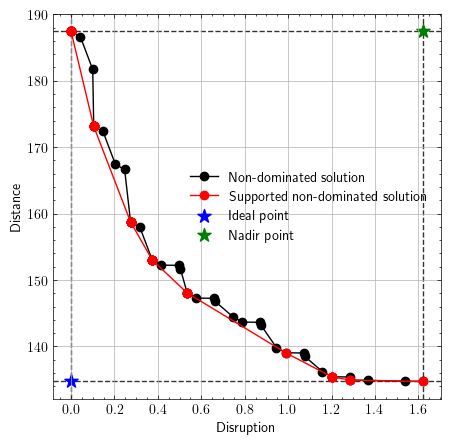

In [ ]:
with plt.style.context('science'):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    ax.plot(F2_eps, F1_eps, "-ok", label="Non-dominated solution")
    # ax.scatter(F2_eps, F1_eps, marker="o", c="k", s=15, label="Non-dominated solution")
    # ax.scatter(F2, F1, marker="o", s=15, c="r", zorder=2.5, label="Supported non-dominated solution")
    ax.plot(F2, F1, "-or", zorder=2.5, label="Supported non-dominated solution")

    ax.scatter(ideal_disruption, ideal_distance, marker="*", s=100, c="b", label="Ideal point")
    ax.axvline(x=ideal_disruption, zorder=0, c="k", linestyle="--", alpha=0.8)
    ax.axhline(y=ideal_distance, zorder=0, c="k", linestyle="--", alpha=0.8)

    ax.scatter(nadir_disruption, nadir_distance, marker="*", s=100, c="g", label="Nadir point")
    ax.axvline(x=nadir_disruption, zorder=0, c="k", linestyle="--", alpha=0.8)
    ax.axhline(y=nadir_distance, zorder=0, c="k", linestyle="--", alpha=0.8)

    # ax.set_title(f"{lb}, {ub}")
    ax.set_xlabel("Disruption")
    ax.set_ylabel("Distance")
    ax.grid()
    ax.legend()

fig.savefig(f"figures/workload_balance_{lb}_{ub}.pdf", dpi=500)
plt.show()


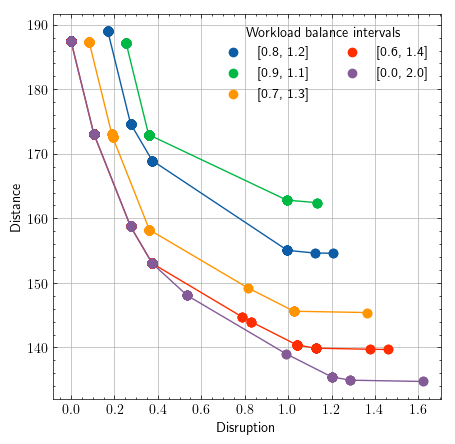

In [ ]:
with plt.style.context('science'):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    for label, f1, f2 in logs:
        ax.scatter(f2, f1, marker="o", label=f"[{label}]")
        ax.plot(f2, f1, "-o")

    # ax.set_title(f"{lb}, {ub}")
    ax.set_xlabel("Disruption")
    ax.set_ylabel("Distance")
    ax.grid()
    ax.legend(title="Workload balance intervals", ncol=2)

fig.savefig(f"figures/workload_balance_summary.pdf", dpi=500)
plt.show()


## Would assigning a brick to multiple SRs improve the solution?

In [ ]:
#monoobjectiv problem
model = gp.Model("pfizer")

workload_balance_lower_bound = 0.8
workload_balance_upper_bound = 1.2

xc = model.addMVar((num_sr, num_bricks), vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0)
xd = model.addMVar((num_sr, num_bricks), vtype=GRB.BINARY)

# https://support.gurobi.com/hc/en-us/articles/4414392016529-How-do-I-model-conditional-statements-in-Gurobi-
EPS = 1e-4
model.addConstrs((
    xc[i][j] >= EPS - (1-xd[i][j])
    for i in range(num_sr)
    for j in range(num_bricks)
))

model.addConstrs((
    xc[i][j] <= xd[i][j]
    for i in range(num_sr)
    for j in range(num_bricks)
))

model.addConstrs((
    workload_balance_lower_bound <= gp.quicksum(index_values[j] * xc[i][j] for j in range(num_bricks))
    for i in range(num_sr)
), name="left_workload_balance")

model.addConstrs((
    gp.quicksum(index_values[j] * xc[i][j] for j in range(num_bricks)) <= workload_balance_upper_bound
    for i in range(num_sr)
), name="right_workload_balance")

model.addConstrs((
    gp.quicksum(xc[i][j] for i in range(num_sr)) == 1
    for j in range(num_bricks)
), name="no_partial_assignments")


# # Minimize the total distance
model.setObjective(
     gp.quicksum(
         distances[i][j] * xd[i][j]
         for i in range(num_sr)
         for j in range(num_bricks)
     ),
     GRB.MINIMIZE
)

# Minimize the total disruption between SRs
#model.setObjective(
#    gp.quicksum(
#        index_values[j] * (xc[i][j] - x_current_structure[i][j]) * (xc[i][j] - x_current_structure[i][j]) / 2
#        for i in range(num_sr)
#        for j in range(num_bricks)
#    ),
#    GRB.MINIMIZE
#)


model.update()
model.optimize()

df = pd.DataFrame(
    xd.x.T,
    columns=[f"SR{i}" for i in range(num_sr)],
    index=[f"Br{i}" for i in range(num_bricks)]
)

get_report(xc.x)


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 206 rows, 176 columns and 616 nonzeros
Model fingerprint: 0xc1015bbe
Variable types: 88 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [8e-01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 470.1300000
Presolve time: 0.00s
Presolved: 206 rows, 176 columns, 616 nonzeros
Variable types: 88 continuous, 88 integer (88 binary)

Root relaxation: objective 1.486289e+02, 106 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  148.62895    0    5  470.13000  148

(1.2055, 154.6)

In [ ]:
# distance (1.7207999999999997, 189.42999999999998)
# disruption (0.010099369797734022, 194.44958456021917)

In [ ]:
F1_with_partial_assignement, F2_with_partial_assignement = [], []
XC, XD = [], []

weights = np.linspace(0.0, 200.0, 100)

for w in tqdm(weights):
    model = gp.Model("pfizer", env=env)
    model.params.outputflag = 0

    workload_balance_lower_bound = 0.8
    workload_balance_upper_bound = 1.2

    xc = model.addMVar((num_sr, num_bricks), vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0)
    xd = model.addMVar((num_sr, num_bricks), vtype=GRB.BINARY)

    # https://support.gurobi.com/hc/en-us/articles/4414392016529-How-do-I-model-conditional-statements-in-Gurobi-
    EPS = 1e-4
    model.addConstrs((
        xc[i][j] >= EPS - (1-xd[i][j])
        for i in range(num_sr)
        for j in range(num_bricks)
    ))

    model.addConstrs((
        xc[i][j] <= xd[i][j]
        for i in range(num_sr)
        for j in range(num_bricks)
    ))

    # Constraints
    model = add_constraints(model, index_values, xc, lb=workload_balance_lower_bound, ub=workload_balance_upper_bound, num_bricks=num_bricks, num_sr=num_sr)

    # minimize the weighted sum between the total distance and the disruption
    f1f2 =  gp.quicksum(
        distances[i][j] * xd[i][j] + w * index_values[j] * (xc[i][j] - x_current_structure[i][j]) * (xc[i][j] - x_current_structure[i][j]) / 2
        for i in range(num_sr)
        for j in range(num_bricks)
    )

    model.setObjective(f1f2, GRB.MINIMIZE)
    model.update()
    model.optimize()

    f1 = sum(
        distances[i][j] * xd.x[i][j]
        for i in range(num_sr)
        for j in range(num_bricks)
    )
    f2 = sum(
        index_values[j] * (xc.x[i][j] - x_current_structure[i][j])**2 / 2
        for i in range(num_sr)
        for j in range(num_bricks)
    )

    F1_with_partial_assignement.append(f1)
    F2_with_partial_assignement.append(f2)
    XC.append(xc.x)
    XD.append(xd.x)


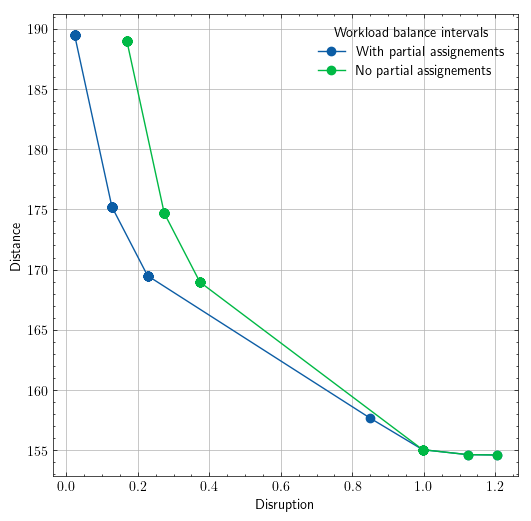

In [ ]:
# plt.plot(F2_with_partial_assignement, F1_with_partial_assignement, "-or", zorder=2.5, label="cont")
# plt.plot(F2_weighted_no_partial_assignement, F1_weighted_no_partial_assignement, "-ok", zorder=2.5, label="disc")
# plt.legend()

with plt.style.context('science'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # for label, f1, f2 in logs:
    #     ax.scatter(f2, f1, marker="o", label=f"[{label}]")
    #     ax.plot(f2, f1, "-o")

    ax.plot(F2_with_partial_assignement, F1_with_partial_assignement, marker="o", zorder=2.5, label="With partial assignements")
    ax.plot(F2_weighted_no_partial_assignement, F1_weighted_no_partial_assignement, marker="o", zorder=2.5, label="No partial assignements")

    # ax.set_title(f"{lb}, {ub}")
    ax.set_xlabel("Disruption")
    ax.set_ylabel("Distance")
    ax.grid()
    ax.legend(title="Workload balance intervals", ncol=1)

fig.savefig(f"figures/cont_disc_comp.pdf", dpi=500)
plt.show()


## What happens when the demand (i.e. the index value) of all bricks increases by 20%?

In [ ]:
#mono-objective problem
lb = 0.8
ub = 1.2

iv = index_values + index_values*0.2

model = gp.Model("pfizer")

workload_balance_lower_bound = 0.8
workload_balance_upper_bound = 1.2

x = model.addMVar((num_sr, num_bricks), vtype=GRB.BINARY)

# Add constraints
model = add_constraints(model, iv, x, lb=0.8, ub=1.2, num_bricks=num_bricks, num_sr=num_sr)

# Minimize the total distance
model.setObjective(
    gp.quicksum(
        distances[i][j] * x[i][j]
        for i in range(num_sr)
        for j in range(num_bricks)
    ),
    GRB.MINIMIZE
)

model.update()
model.optimize()


##No feasible solution for the mono-objective problem considering +20% in the demand and without hiring new SR

## Why 20% is the percentage from which we have to hire a new SR?

In [ ]:
percentages = np.linspace(0.0, 0.5, 100)

lb = 0.8
ub = 1.2

all_non_dominated_solutions = []

for p in tqdm(percentages):
    iv = index_values + index_values*p

    F1, F2, X = epsilon_constrain_method(
        x_current_structure=x_current_structure,
        index_values=iv,
        workload_balance_lower_bound=lb,
        workload_balance_upper_bound=ub,
    )


    # model = gp.Model("pfizer", env=env)
    # model.params.outputflag = 0

    # # Decision variables
    # x = model.addMVar((num_sr, num_bricks), vtype=GRB.BINARY)

    # # Add constraints
    # model = add_constraints(model, iv, x, lb=lb, ub=ub, num_bricks=num_bricks, num_sr=num_sr)

    # # Minimize the total distance
    # model.setObjective(
    #     gp.quicksum(
    #         distances[i][j] * x[i][j]
    #         for i in range(num_sr)
    #         for j in range(num_bricks)
    #     ),
    #     GRB.MINIMIZE
    # )

    # model.update()
    # model.optimize()

    # if model.status == 3:
    #     print(f"When demand increases by {p}:", "An optimal solution is available." if model.status == 2 else "Model was proven to be infeasible.")
    #     break
    print(f"p={p*100}%", len(set(F1)))

    all_non_dominated_solutions.append([p, len(set(F1))])



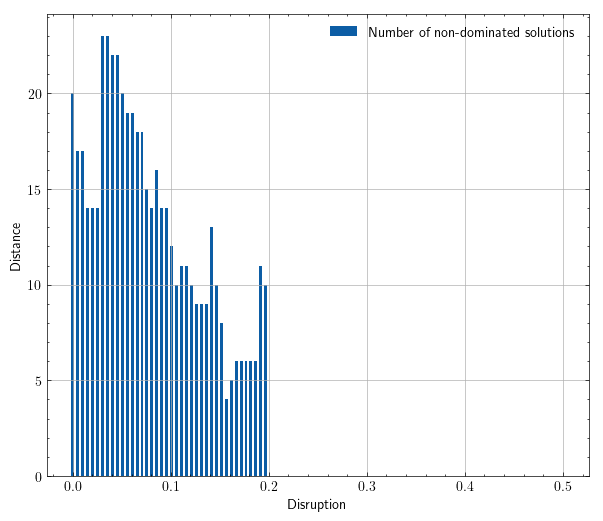

In [ ]:
all_non_dominated_solutions = np.array(all_non_dominated_solutions)

with plt.style.context('science'):
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))

    # plt.bar(q[:,0], q[:,1], width=0.8)
    # plt.bar(np.linspace(20, 40, 100), np.zeros((100,)), width=0.4)

    ax.bar(all_non_dominated_solutions[:, 0], all_non_dominated_solutions[:, 1], width=3e-3, label="Number of non-dominated solutions")

    # ax.set_title(f"{lb}, {ub}")
    ax.set_xlabel("Disruption")
    ax.set_ylabel("Distance")
    ax.grid()
    ax.legend()

fig.savefig(f"figures/increase_demand.pdf", dpi=500)
plt.show()


## Would hiring a new SR solve this demand increase?

In [ ]:
F1_hire_new_sr = []
F2_hire_new_sr = []
center_brick = []
X = []

iv = index_values + index_values*0.2

workload_balance_lower_bound = 0.8
workload_balance_upper_bound = 1.2

weights = np.linspace(0.0, 200.0, 100)

for w in tqdm(weights):
    model = gp.Model("pfizer", env=env)
    model.params.outputflag = 0

    # Add the fifth SR
    sr = num_sr + 1

    x = model.addMVar((sr, num_bricks), vtype=GRB.BINARY)

    # Center brick of the fifth SR
    c = model.addMVar((num_bricks), vtype=GRB.BINARY)
    model.addConstr((
        gp.quicksum(c[i] for i in range(num_bricks)) == 1
    ))

    # Add constraints
    model = add_constraints(model, iv, x, lb=workload_balance_lower_bound, ub=workload_balance_upper_bound, num_bricks=num_bricks, num_sr=sr)

    # minimize the weighted sum between the total distance and the disruption
    f1f2 =  (
        gp.quicksum(
            distances[i][j] * x[i][j]
            for i in range(sr-1)
            for j in range(num_bricks)
        ) +\
        gp.quicksum(
            sum(distances_between_bricks[j, :] * c) * x[4][j]
            for j in range(num_bricks)
        ) +\
        w * gp.quicksum(
            index_values[j] * (x[i][j] - x_current_structure[i][j]) * (x[i][j] - x_current_structure[i][j]) / 2
            for i in range(num_sr)
            for j in range(num_bricks)
        )
    )

    model.setObjective(f1f2, GRB.MINIMIZE)
    model.update()
    model.optimize()

    f1 = sum(
        distances[i][j] * x.x[i][j]
        for i in range(sr-1)
        for j in range(num_bricks)
    )+\
    sum(
        sum(distances_between_bricks[j, :] * c.x) * x.x[4][j]
        for j in range(num_bricks)
    )

    f2 = sum(
        index_values[j] * (x.x[i][j] - x_current_structure[i][j]) * (x.x[i][j] - x_current_structure[i][j]) / 2
        for i in range(num_sr)
        for j in range(num_bricks)
    )

    F1_hire_new_sr.append(f1)
    F2_hire_new_sr.append(f2)
    center_brick.append(np.argmax(c.x) +1)
    X.append(x.x)
    print("The center brick of the fifth SR is:", np.argmax(c.x) +1)


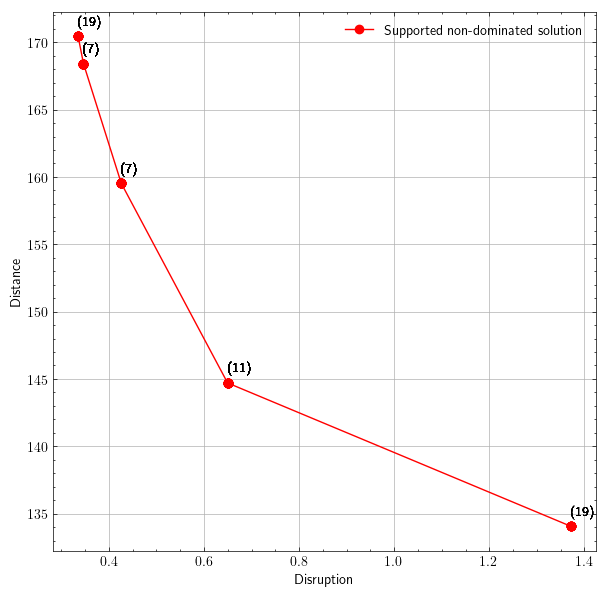

In [ ]:
with plt.style.context('science'):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))

    ax.plot(F2_hire_new_sr, F1_hire_new_sr, "-or", label="Supported non-dominated solution")

    for i, (a, b) in enumerate(zip(F2_hire_new_sr, F1_hire_new_sr)):
        ax.text(a, b+8e-1, f"({center_brick[i]})")

    ax.set_xlabel("Disruption")
    ax.set_ylabel("Distance")
    ax.grid()
    ax.legend()

fig.savefig(f"figures/center_brick_non_dominated.pdf", dpi=500)
plt.show()


In [ ]:
iv = index_values + index_values*0.2

model = gp.Model("pfizer")

workload_balance_lower_bound = 0.8
workload_balance_upper_bound = 1.2

# Add the fifth SR
sr = num_sr + 1

x = model.addMVar((sr, num_bricks), vtype=GRB.BINARY)

# Center brick of the fifth SR
c = model.addMVar((num_bricks), vtype=GRB.BINARY)
model.addConstr((
    gp.quicksum(c[i] for i in range(num_bricks)) == 1
))

# Add constraints
model = add_constraints(model, iv, x, lb=workload_balance_lower_bound, ub=workload_balance_upper_bound, num_bricks=num_bricks, num_sr=sr)

# Minimize the total distance
model.setObjective(
    gp.quicksum(
        distances[i][j] * x[i][j]
        for i in range(sr-1)
        for j in range(num_bricks)
    ) +\
    gp.quicksum(
        sum(distances_between_bricks[j, :] * c) * x[4][j]
        for j in range(num_bricks)
    ),
    GRB.MINIMIZE
)

model.update()
model.optimize()
print("The center brick of the fifth SR is:", np.argmax(c.x) +1)


In [ ]:
print("The center brick of the fifth SR is:", np.argmax(c.x) +1)

The center brick of the fifth SR is: 19


## What happens when we change the center bricks of all SRs?

In [ ]:
num_sr, num_bricks

(4, 22)

In [ ]:
supp_nd_F1_relocate_all_new_sr = []
supp_nd_F2_relocate_all_new_sr = []
center_brick = []
X = []

workload_balance_lower_bound = 0.8
workload_balance_upper_bound = 1.2

weights = np.linspace(0.0, 200.0, 100)

for w in tqdm(weights):
    model = gp.Model("pfizer", env=env)
    model.params.outputflag = 0

    x = model.addMVar((num_sr, num_bricks), vtype=GRB.BINARY)

    c = model.addMVar((num_sr, num_bricks), vtype=GRB.BINARY)
    model.addConstrs((
        gp.quicksum(c[i][j] for j in range(num_bricks)) == 1
        for i in range(num_sr)
    ))

    # model.addConstrs((
    #     gp.quicksum(c[i][j] for i in range(num_sr)) <= 1
    #     for j in range(num_bricks)
    # ))

    # Constraints
    model = add_constraints(model, index_values, x, lb=workload_balance_lower_bound, ub=workload_balance_upper_bound, num_bricks=num_bricks, num_sr=num_sr)

    # minimize the weighted sum between the total distance and the disruption
    f1f2 =  (
        gp.quicksum(
            gp.quicksum(distances_between_bricks[j, :] * c[i]) * x[i][j]
            for i in range(num_sr)
            for j in range(num_bricks)
        ) +\
        w * gp.quicksum(
            index_values[j] * (x[i][j] - x_current_structure[i][j]) * (x[i][j] - x_current_structure[i][j]) / 2
            for i in range(num_sr)
            for j in range(num_bricks)
        )
    )

    model.setObjective(f1f2, GRB.MINIMIZE)
    model.update()
    model.optimize()

    f1 = sum(
        sum(distances_between_bricks[j, :] * c.x[i]) * x.x[i][j]
        for i in range(num_sr)
        for j in range(num_bricks)
    )

    f2 = sum(
        index_values[j] * (x.x[i][j] - x_current_structure[i][j]) * (x.x[i][j] - x_current_structure[i][j]) / 2
        for i in range(num_sr)
        for j in range(num_bricks)
    )

    supp_nd_F1_relocate_all_new_sr.append(f1)
    supp_nd_F2_relocate_all_new_sr.append(f2)


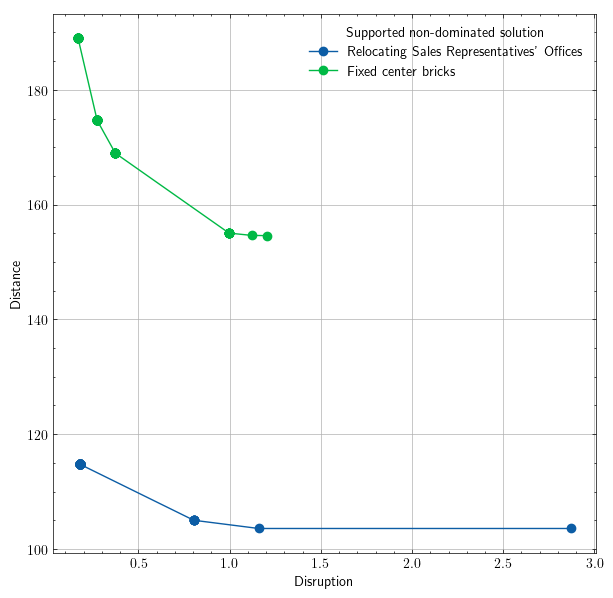

In [ ]:
with plt.style.context('science'):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))

    ax.plot(supp_nd_F2_relocate_all_new_sr, supp_nd_F1_relocate_all_new_sr, "-o", label="Relocating Sales Representatives' Offices")
    ax.plot(F2_weighted_no_partial_assignement, F1_weighted_no_partial_assignement, "-o", label="Fixed center bricks")

    ax.set_xlabel("Disruption")
    ax.set_ylabel("Distance")
    ax.grid()
    ax.legend(title="Supported non-dominated solution")

fig.savefig(f"figures/center_brick_non_dominated.pdf", dpi=500)
plt.show()


In [ ]:
lb = 0.8
ub = 1.2

iv = index_values

model = gp.Model("pfizer")

workload_balance_lower_bound = 0.8
workload_balance_upper_bound = 1.2

x = model.addMVar((num_sr, num_bricks), vtype=GRB.BINARY)

c = model.addMVar((num_sr, num_bricks), vtype=GRB.BINARY)
model.addConstrs((
    gp.quicksum(c[i][j] for j in range(num_bricks)) == 1
    for i in range(num_sr)
))

model.addConstrs((
    gp.quicksum(c[i][j] for i in range(num_sr)) <= 1
    for j in range(num_bricks)
))


# Constraints
model = add_constraints(model, index_values, x, lb=workload_balance_lower_bound, ub=workload_balance_upper_bound, num_bricks=num_bricks, num_sr=num_sr)

# Minimize the total distance
model.setObjective(
    gp.quicksum(
        sum(distances_between_bricks[j, :] * c[i]) * x[i][j]
        for i in range(num_sr)
        for j in range(num_bricks)
    ),
    GRB.MINIMIZE
)

model.update()
model.optimize()


In [ ]:
np.argmax(c.x, axis=1)+1

array([ 2,  6, 15, 18])

In [ ]:
get_report(x.x)

Structure of Sales Territories:
SR1 (iv:1.007 - distance:136.220): [ 1  2  3 19 20 21 22]
SR2 (iv:0.834 - distance:67.290): [ 4  5  6  7  8  9 12]
SR3 (iv:1.131 - distance:8.430): [10 11 15 16]
SR4 (iv:1.029 - distance:174.010): [13 14 17 18]
Disruption: 3.5376999999999996
Total distance: 385.95000000000005


(3.5376999999999996, 385.95000000000005)

In [ ]:
sum(
    sum(distances_between_bricks[j, :] * c.x[i]) * x.x[i][j]
    for i in range(num_sr)
    for j in range(num_bricks)
),


(103.56395980541879,)

## Fix % and number of SRs. Find p1 and p2

In [ ]:
lb = 0.8
ub = 1.2

k = 0
sr = num_sr + k
iv = index_values + index_values*0.3

model = gp.Model("pfizer", env=env)

workload_balance_lower_bound = model.addMVar((1,), vtype=GRB.CONTINUOUS, lb=0.8)
workload_balance_upper_bound = model.addMVar((1,), vtype=GRB.CONTINUOUS)

x = model.addMVar((sr, num_bricks), vtype=GRB.BINARY)

# c = model.addMVar((k, num_bricks), vtype=GRB.BINARY)
# model.addConstrs((
#     gp.quicksum(c[i][j] for j in range(num_bricks)) == 1
#     for i in range(k)
# ))


# Constraints
model = add_constraints(model, iv, x, lb=workload_balance_lower_bound, ub=workload_balance_upper_bound, num_bricks=num_bricks, num_sr=sr)

# Minimize the total distance
model.setObjective(
    gp.quicksum(
        distances[i][j] * x[i][j]
        for i in range(num_sr)
        for j in range(num_bricks)
    ),
    GRB.MINIMIZE
)

model.update()
model.optimize()

print(k, model.status)
# if model.status == 3:
#     print(f"{k} don't work")
#     break


In [ ]:
workload_balance_lower_bound.x, workload_balance_upper_bound.x

(array([0.8]), array([2.]))

# Preference Learning

##Preference in term of assignement of SRs

In [ ]:
weight_list=[]
dist_list=[]
disruption_list = []
weights = np.arange(0,4,0.01)
#weights = np.linspace(0,100,500)
num_sr = 4
num_bricks = 22
workload_balance_lower_bound = 0.8
workload_balance_upper_bound = 1.2
pref1 = pd.read_csv("/content/preferences1.csv")
pref1 = np.array(pref1)
pref = pref1
for weight in weights:
  model = gp.Model("pfizer")
  model.params.outputflag = 0
  x = model.addMVar((num_sr, num_bricks), vtype=GRB.BINARY)
  #model = add_constraints(model, index_values, x, lb=workload_balance_lower_bound, ub=workload_balance_upper_bound, num_bricks=num_bricks, num_sr=num_sr)
  #obj = gp.quicksum(distances[i][j]*x[i][j] + weight*x[i][j]*pref[j][i] for i in range(num_sr) for j in range(num_bricks))

  model.setObjective(gp.quicksum(
        distances[i][j] * x[i][j] + weight*x[i][j]*pref[j][i]
        for i in range(num_sr)
        for j in range(num_bricks)
    ), GRB.MINIMIZE)
  model.update()
  model.optimize()
  #print(model.status)
  if model.status == 2:
    weight_list.append(weight)
    dist = sum(
            distances[i][j] * x.x[i][j]
            for i in range(num_sr)
            for j in range(num_bricks)
        )
    dispution = sum(
        index_values[j] * (x.x[i][j] - x_current_structure[i][j]) * (x.x[i][j] - x_current_structure[i][j]) / 2
        for i in range(num_sr)
        for j in range(num_bricks)
    )
    dist_list.append(dist)
    disruption_list.append(dispution)

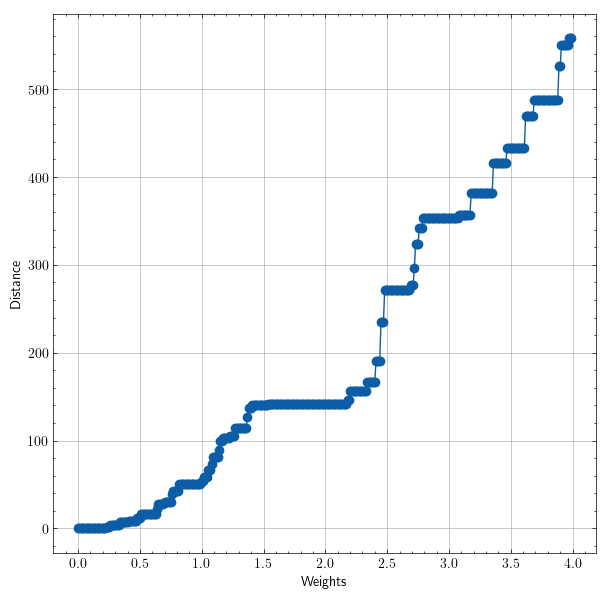

In [ ]:
with plt.style.context('science'):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))

    ax.plot(weights, dist_list, "-o", label="Relocating Sales Representatives' Offices")
    #ax.plot(F2_weighted_no_partial_assignement, F1_weighted_no_partial_assignement, "-o", label="Fixed center bricks")

    ax.set_xlabel("Weights")
    ax.set_ylabel("Distance")
    ax.grid()

fig.savefig(f"figures/weights_and_distances.pdf", dpi=500)
plt.show()

##Preference in terme of solution

In [ ]:
from gurobipy import *

def rank(list_alternatives,partial_ranking,L):

    nb_alternatives = len(partial_ranking)
    nb_criteria = len(partial_ranking[0])

    epsilon = 0.001

    min_criterion = [np.min(list_alternatives[:,i]) for i in range(nb_criteria)]
    max_criterion = [np.max(list_alternatives[:,i]) for i in range(nb_criteria)]

    values = []
    for i in range(nb_criteria):
        values_criterion = []
        for j in range(L+1):
            values_criterion.append(min_criterion[i] + j * (max_criterion[i] - min_criterion[i]) / L)
        values.append(values_criterion)

    m = Model("TD8-Ex2")

    # Variables de bruit :
    noise_pos = {i : m.addVar(vtype=GRB.CONTINUOUS, lb = 0, name=f'noise-pos_{i}') for i in range(nb_alternatives)}
    noise_neg = {i : m.addVar(vtype=GRB.CONTINUOUS, lb = 0, name=f'noise-neg_{i}') for i in range(nb_alternatives)}

    # Variables de découpage linéaire sur la fonction de valeur des critères
    s = {(i, j) : m.addVar(vtype = GRB.CONTINUOUS, name=f's_{i}_{j}') for j in range(L+1) for i in range(nb_criteria)}

    # estimated value of the evaluation of the alternatives
    estimate = {(i, j) : m.addVar(vtype = GRB.CONTINUOUS, name=f'estimate_{i}_{j}') for j in range(nb_criteria) for i in range(nb_alternatives)}

    # Contraintes de normalisation
    lower_bound = {i : m.addConstr(s[i,0] == 0, name = "lower_bound_normalization") for i in range(nb_criteria)}
    sum_to_one = m.addConstr((quicksum(s[i,L] for i in range(nb_criteria))) == 1, name = "sum_to_one")

    # Contraintes de monotonie
    monotonicity = {i : {k : m.addConstr(s[i,k+1] >= s[i,k], name = "monotonicity") for k in range(L)} for i in range(nb_criteria)}

    # Contraintes de préférences
    for i in range(nb_alternatives):
        for j in range(nb_criteria):
            for k in range(L):
                if values[j][k] <= partial_ranking[i][j] <= values[j][k+1]:
                    m.addConstr(estimate[i,j] == s[j,k] + ((partial_ranking[i][j] - values[j][k]) / (values[j][k+1] - values[j][k])) * (s[j,k+1] - s[j,k]), name = f'estimate_{i}_{j}')
    pref = {i : m.addConstr(
        quicksum([estimate[(i, j)] for j in range(nb_criteria)]) - quicksum([estimate[(l, j)] for j in range(nb_criteria) for l in range(nb_alternatives) if l == i+1]) - noise_pos[i] + noise_neg[i] >=  - noise_pos[i+1] + noise_neg[i+1] + epsilon) for i in range(nb_alternatives-1)}

    # Fonction objectif
    m.setObjective(sum(noise_pos[i] + noise_neg[i] for i in range(nb_alternatives)), GRB.MINIMIZE)

    m.update()
    #print(m.display())

    # -- Choix d'un paramétrage d'affichage minimaliste --
    m.params.outputflag = 0 # mode muet

    # -- Résolution --
    m.optimize()

    # -- Vérification du statut et Affichage (le cas échéant) des solutions --
    if m.status == GRB.INF_OR_UNBD:
        m.setParam(GRB.Param.Presolve, 0)
        m.optimize()

    if m.status == GRB.INFEASIBLE:
        print(m.display(), "\n\tN'A PAS DE SOLUTION!!!")
        return None
    elif m.status == GRB.UNBOUNDED:
        print(m.display(), "\n\tEST NON BORNÉ!!!")
        return None
    else:
        # Affichage des fonctions linéaires par morceaux :
        #print(m.objVal)
        #print()
        #for i in range(nb_criteria):
        #    for j in range(L):
        #        print(s[i,j].x, end = " ")
        #    print(s[i,L].x)
        #print()


        final_evaluations = np.zeros(len(list_alternatives))
        for i in range(len(list_alternatives)):
            eval = 0
            for j in range(nb_criteria):
                eval_criterion = 0
                for k in range(L):
                    if values[j][k] <= list_alternatives[i][j] <= values[j][k+1]:
                        eval_criterion = s[j,k].x + (list_alternatives[i][j] - values[j][k]) / (values[j][k+1] - values[j][k]) * (s[j,k+1].x - s[j,k].x)
                eval = eval + eval_criterion
            final_evaluations[i] = eval
            #print(eval)

        # Tri (et affichage) des tuples décrivant les évaluations des alternatives sur les différents critères en fonction de la fonction d'utilité linéaire par morceaux déduite
        #zipped_lists = zip(final_evaluations,list_alternatives)
        #sorted_zipped_lists = sorted(zipped_lists, key=lambda x: x[0], reverse=True)
        #sorted_alternatives = [element for _, element in sorted_zipped_lists]
        #print(sorted_alternatives)

        # Output : l'ordre de préférence déduit sur les alternatives (les alternatives sont représentées par leur indice dans le tableau de départ)
        return sorted(range(len(final_evaluations)), key=lambda k: final_evaluations[k], reverse=True)


# print("Le nouveau classement des universités est le suivant : ",rank(new_universities,reference_universities,4))
# print("Le nouveau classement des voitures est le suivant : ",rank(new_cars,reference_cars,4))

In [ ]:
F21 = np.array([
    [1.2055e+00, 1.5460e+02],
    [1.1227e+00, 1.5463e+02],
    [9.9670e-01, 1.5504e+02],
    [9.6250e-01, 1.6063e+02],
    [8.9700e-01, 1.6076e+02],
    [8.4250e-01, 1.6342e+02],
    [8.2780e-01, 1.6467e+02],
    [7.9580e-01, 1.6468e+02],
    # [5.8640e-01, 1.6596e+02],
    # [4.9960e-01, 1.6647e+02],
    # [4.5690e-01, 1.6725e+02],
    # [4.3100e-01, 1.6819e+02],
    [3.7360e-01, 1.6896e+02],
    # [3.5720e-01, 1.7297e+02],
    [3.3130e-01, 1.7391e+02],
    [2.7390e-01, 1.7468e+02],
    # [2.6930e-01, 1.8323e+02],
    # [2.5290e-01, 1.8724e+02],
    [2.2700e-01, 1.8818e+02],
    [1.6960e-01, 1.8895e+02]
])

train = np.array([
    [  0.4569, 167.25  ],
    [  0.431 , 168.19  ],
    [  0.4996, 166.47  ],
    [  0.5864, 165.96  ],
    [3.5720e-01, 1.7297e+02],
    [  0.2693, 183.23  ],
    [  0.2529, 187.24  ],
    # [  0.227 , 188.18  ],
    [1.2055e+00, 1.5460e+02],
])

indices = rank(F21, train, 10)
F21[indices, ...]


array([[3.7360e-01, 1.6896e+02],
       [3.3130e-01, 1.7391e+02],
       [2.7390e-01, 1.7468e+02],
       [1.2055e+00, 1.5460e+02],
       [2.2700e-01, 1.8818e+02],
       [1.6960e-01, 1.8895e+02],
       [7.9580e-01, 1.6468e+02],
       [8.2780e-01, 1.6467e+02],
       [8.4250e-01, 1.6342e+02],
       [1.1227e+00, 1.5463e+02],
       [9.9670e-01, 1.5504e+02],
       [9.6250e-01, 1.6063e+02],
       [8.9700e-01, 1.6076e+02]])

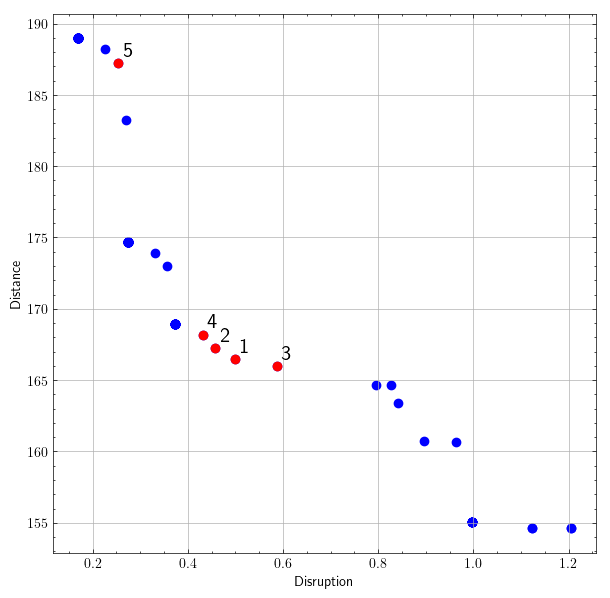

In [ ]:
with plt.style.context('science'):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))

    ax.scatter(F2_weighted_no_partial_assignement, F1_weighted_no_partial_assignement, c="b", label="")
    ax.scatter(F2_epsilon_method_no_partial_assignement, F1_epsilon_method_no_partial_assignement, c="b", label="")

    # for i, (a, b) in enumerate(zip(F2_epsilon_method_no_partial_assignement, F1_epsilon_method_no_partial_assignement)):
    #     ax.text(a+1e-2, b+5e-1, i, size=15)

    # plt.scatter(0.4996, 166.47, c="r")

    plt.scatter(A[:, 0], A[:, 1], c="r")
    for i, (a, b) in enumerate(zip(A[:, 0], A[:, 1])):
        ax.text(a+1e-2, b+5e-1, i+1, size=15)


    ax.set_xlabel("Disruption")
    ax.set_ylabel("Distance")
    ax.grid()
    # ax.legend()

fig.savefig(f"figures/preference_2.pdf", dpi=500)
plt.show()


In [ ]:
F21 = np.array([
    [2.5290e-01, 1.8724e+02],
    [4.9960e-01, 1.6647e+02],
    [2.6930e-01, 1.8323e+02],
    [4.5690e-01, 1.6725e+02],
    [4.3100e-01, 1.6819e+02],
    [3.5720e-01, 1.7297e+02],
    [5.8640e-01, 1.6596e+02],
])

train = np.array([
    [9.6250e-01, 1.6063e+02], # 4

    [2.7390e-01, 1.7468e+02],
    [9.9670e-01, 1.5504e+02],
    [2.2700e-01, 1.8818e+02],
    [1.1227e+00, 1.5463e+02],
    [1.6960e-01, 1.8895e+02],
    [1.2055e+00, 1.5460e+02],



    # [8.9700e-01, 1.6076e+02],
    # [8.4250e-01, 1.6342e+02],
    # [8.2780e-01, 1.6467e+02],
    # [7.9580e-01, 1.6468e+02],
    # [3.3130e-01, 1.7391e+02],
    # [2.7390e-01, 1.7468e+02],
    # [3.3130e-01, 1.7391e+02],
    # [2.7390e-01, 1.7468e+02],
    # [2.2700e-01, 1.8818e+02],
    # [3.3130e-01, 1.7391e+02],
])

indices = rank(F21, train, 10)[:5]
A = F21[indices, ...]
